In [1]:
import xarray as xr
import os.path
import pandas as pd
from glob import glob
import xesmf as xe

import matplotlib.pyplot as plt
import numpy as np

In [2]:
input_path = '/gws/nopw/j04/impala/shared/input4MIPS/'
path_f = input_path+'/{species}*-{scenario}-1-1_gn*.nc'
output_path = '/home/users/dwatsonparris/ClimateBench/'
path_f_csv = input_path+'/{species}*-{scenario}-1-1_gn*.csv'

In [3]:
experiments = [
               'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF', 'ssp585' #	ScenarioMIP
]

In [4]:
# All units are in kg m-2 s-1
# Convert to GtC -> multiply by area of earth, period I've summed, and divide by weight of carbon
AREA_OF_EARTH = 5.101e+14 #m2
SECONDS_IN_YEAR = 60*60*24*365 #s
MASS_OF_CARBON = 1.9944235e-26  #kg
FRACTION_OF_CARBON_MASS = (6) / (6 + 8 + 8)

convert = lambda x: x * AREA_OF_EARTH * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

def global_mean(ds):
    if 'plev' in ds.coords:
        res = ds.sum('plev')
    else:
        res = ds
        
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    gl_mean = res.weighted(weights).mean(("lon", "lat"))
    
    return gl_mean

def global_sum(ds):
    if 'plev' in ds.coords:
        res = ds.sum('plev')
    else:
        res = ds
        
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    gl_total = res.weighted(weights).sum(("lon", "lat")) * AREA_OF_EARTH
    
    return gl_total

# Setup regridding

In [5]:
noresm_grid = xr.open_dataset(output_path+'/NorESM2-LM_ssp585_r1i1p1f1.nc')

In [6]:
example_input4MIPs_ds = xr.open_mfdataset(path_f.format(species="CO2", scenario='ssp585'), combine='by_coords').sum('sector')
regridder = xe.Regridder(example_input4MIPs_ds, noresm_grid.rename({'lat': 'latitude', 'lon': 'longitude'}), 'conservative', periodic=True)

/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [7]:
coarse_emissions = regridder(example_input4MIPs_ds)

/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


<xarray.DataArray 'CO2_em_anthro' ()>
array(2.63778652e-05)


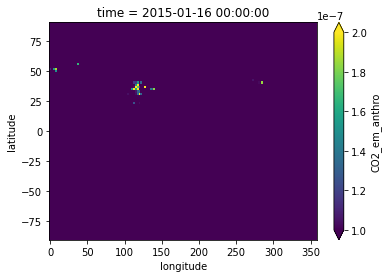

In [8]:
print(coarse_emissions.sel(time='2015-01')['CO2_em_anthro'].sum().compute())
coarse_emissions.sel(time='2015-01')['CO2_em_anthro'].squeeze().plot.pcolormesh(vmin=1e-7, vmax=2e-7)

<xarray.DataArray 'CO2_em_anthro' ()>
array(0.00050094, dtype=float32)


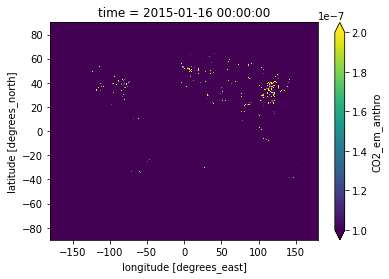

In [9]:
print(example_input4MIPs_ds.sel(time='2015-01')['CO2_em_anthro'].sum().compute())
example_input4MIPs_ds.sel(time='2015-01')['CO2_em_anthro'].squeeze().plot.pcolormesh(vmin=1e-7, vmax=2e-7)

# Get input4MIPS

In [10]:
# For CO2 I might want to do a cumsum (especially since i'm using mass from the idealised simulations)
# For SO2 I took a difference from PD (2015-2020) before but I don't think I should do that now, they can experiment with it

In [11]:
# Deal with CMIP experiments

# get the baseline CO2 mass from piControl

# CO2 mass in kg
baseline_co2_mass = xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_piControl*.nc')['co2mass'].mean()

# 1pctCO2

# (additional) CO2 mass in kg
co2_ts = (xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_1pctCO2*.nc')['co2mass'].groupby('time.year').mean() - baseline_co2_mass).rename('CO2')
so2_ts = xr.zeros_like(co2_ts).rename('SO2')
ch4_ts = xr.zeros_like(co2_ts).rename('CH4')
bc_ts = xr.zeros_like(co2_ts).rename('BC')

ds = xr.merge([co2_ts, so2_ts, ch4_ts, bc_ts])
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_1pctCO2.nc')

# abrupt-4xCO2

# (additional) CO2 mass in kg
co2_ts = (xr.open_mfdataset(input_path+'/co2mass_Amon_NorESM2-LM_abrupt-4xCO2*.nc')['co2mass'].groupby('time.year').mean() - baseline_co2_mass).rename('CO2')
so2_ts = xr.zeros_like(co2_ts).rename('SO2')
ch4_ts = xr.zeros_like(co2_ts).rename('CH4')
bc_ts = xr.zeros_like(co2_ts).rename('BC')

ds = xr.merge([co2_ts, so2_ts, ch4_ts, bc_ts])
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_abrupt-4xCO2.nc')


<xarray.Dataset>
Dimensions:  (year: 150)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 143 144 145 146 147 148 149 150
Data variables:
    CO2      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SO2      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CH4      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    BC       (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (year: 500)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500
Data variables:
    CO2      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SO2      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CH4      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    BC       (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>


In [12]:
all_files = glob(input_path+'/CO2-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_*.csv')
co2_air=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in all_files)) 
co2_air=co2_air.groupby(level=['year']).sum() / 1e6
all_files = glob(input_path+'/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_*.csv')
co2=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in all_files)) 
co2=co2.groupby(level=['year']).sum() / 1e6
co2_tot = (co2_air + co2)[100:]
co2_tot

,global_total
year,
1850,0.188297
1851,0.188947
1852,0.196570
1853,0.205034
1854,0.241471
...,...
2010,32.892259
2011,33.919973
2012,34.398774


In [13]:
all_files = glob(input_path+'/CH4-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.csv')
ch4=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']).rename(columns={'value': 'global_total'}) for f in all_files)) 
# ch4.groupby(level=['year']).sum().plot(marker='x')
# ch4.groupby(level=['year']).sum().reindex(range(1850, 2014)).interpolate('linear').plot(marker='x')
# Fill in the data up to 1970
ch4 = ch4.groupby(level=['year']).sum().reindex(range(1850, 2015)).interpolate('linear') / 1e6
# Note the AIR component for methane is zero over the historical period
ch4

,global_total
year,
1850,0.031306
1851,0.031742
1852,0.032178
1853,0.032614
1854,0.033049
...,...
2010,0.357019
2011,0.360551
2012,0.366511


In [14]:
# historical

hist_co2_ts = xr.DataArray(co2_tot.cumsum()['global_total'], name='CO2')
hist_so2_ts = regridder(xr.open_mfdataset(input_path+'/SO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.nc')['SO2_em_anthro'].sum('sector').groupby('time.year').mean().sel(year=slice(1850, None)).rename('SO2'))
hist_ch4_ts = xr.DataArray(ch4['global_total'], name='CH4')
hist_bc_ts = regridder(xr.open_mfdataset(input_path+'/BC-em-anthro_input4MIPs_emissions_CMIP_CEDS-*.nc')['BC_em_anthro'].sum('sector').groupby('time.year').mean().sel(year=slice(1850, None)).rename('BC'))

print(co2_ts)
print(bc_ts)
print(ch4_ts)
ds = xr.merge([hist_co2_ts, hist_so2_ts, hist_ch4_ts, hist_bc_ts], fill_value=0.) # Set a fill value to set the methane to zero before 1970..
# Fix some metadata to help iris
ds.latitude.attrs['units'] = 'degrees'    
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_historical.nc')

/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'CO2' (year: 500)>
dask.array<sub, shape=(500,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500
<xarray.DataArray 'BC' (year: 500)>
dask.array<full, shape=(500,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500
<xarray.DataArray 'CH4' (year: 500)>
dask.array<full, shape=(500,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500
<xarray.Dataset>
Dimensions:    (year: 165, longitude: 144, latitude: 96)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO2        (y

In [15]:
# Deal with DAMIP experiments
'hist-GHG', 'hist-aer', 'hist-nat', 'hist-piAer', 'hist-piNTCF'

# hist-GHG
# Time varying global annual mean concentrations for CO2 and other long-lived greenhouse-gases 
# https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=hist-ghg

ds = xr.merge([hist_co2_ts, 
               hist_ch4_ts, 
               xr.zeros_like(co2_ts).rename('BC'),
               xr.zeros_like(co2_ts).rename('SO2'),
              ])
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_hist-GHG.nc')

# hist-aer
# forced by changes in anthropogenic aerosol forcing only 
# https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=hist-aer

ds = xr.merge([xr.zeros_like(co2_ts).rename('CO4'), 
               xr.zeros_like(co2_ts).rename('CH4'), 
               hist_bc_ts,
               hist_so2_ts,
              ])
# Fix some metadata to help iris
ds.latitude.attrs['units'] = 'degrees'    
print(ds)
ds.rename({'year': 'time'}).to_netcdf('inputs_hist-aer.nc')



<xarray.Dataset>
Dimensions:  (year: 665)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 2008 2009 2010 2011 2012 2013 2014
Data variables:
    CO2      (year) float64 nan nan nan nan ... 1.429e+03 1.465e+03 1.5e+03
    CH4      (year) float64 nan nan nan nan nan ... 0.3606 0.3665 0.3698 0.3712
    BC       (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SO2      (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
<xarray.Dataset>
Dimensions:    (year: 665, longitude: 144, latitude: 96)
Coordinates:
  * year       (year) int64 1 2 3 4 5 6 7 ... 2008 2009 2010 2011 2012 2013 2014
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO4        (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CH4        (year) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    BC         (year, latitude, longitude) float64 dask.array<

ssp126


/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.543e+03 ... 1.662e+03 1.661e+03
    SO2        (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    CH4        (year) float64 0.3737 0.3657 0.3576 ... 0.115 0.1143 0.1136
    BC         (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
ssp245


/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.544e+03 ... 1.842e+03 1.844e+03
    SO2        (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    CH4        (year) float64 0.3737 0.3737 0.3737 ... 0.281 0.2807 0.2803
    BC         (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
ssp370


/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.544e+03 ... 2.09e+03 2.098e+03
    SO2        (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    CH4        (year) float64 0.3737 0.3796 0.3855 ... 0.7414 0.7455 0.7496
    BC         (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
ssp370-lowNTCF


/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.544e+03 ... 2.105e+03 2.113e+03
    SO2        (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    CH4        (year) float64 0.3737 0.3766 0.3795 ... 0.2075 0.2086 0.2097
    BC         (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
ssp585


/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/users/dwatsonparris/miniconda3/envs/xarray/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:    (year: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * year       (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (year) float64 1.536e+03 1.544e+03 ... 2.366e+03 2.379e+03
    SO2        (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>
    CH4        (year) float64 0.3737 0.3755 0.3773 ... 0.4715 0.4684 0.4653
    BC         (year, latitude, longitude) float64 dask.array<chunksize=(86, 96, 144), meta=np.ndarray>


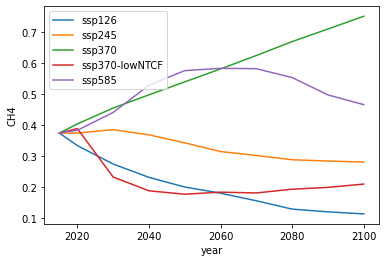

In [16]:

for exp in experiments:
    print(exp)
    
    co2_files = glob(path_f_csv.format(species="CO2", scenario=exp))
    co2=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in co2_files)).groupby(level=['year']).sum() / 1e6
    # Get the *cumulative* CO2 mass in atmosphere
    co2_ts = xr.DataArray(co2.cumsum()['global_total'], name='CO2') + hist_co2_ts[-1]  # Be sure to add the current total in 2015


    so2_f = path_f.format(species="SO2", scenario=exp)
    so2_da = xr.open_mfdataset(so2_f, combine='by_coords')['SO2_em_anthro']
    # Get a the current SO2 emissions
    so2_ts = regridder(so2_da.sum('sector').groupby('time.year').mean())
    
    ch4_files = glob(path_f_csv.format(species="CH4", scenario=exp))
    ch4=pd.concat((pd.read_csv(f, index_col=['year', 'month', 'sector']) for f in ch4_files)).groupby(level=['year']).sum() / 1e3 # The SSP data is in Mt 
    # Get the current CH4 emissions
    ch4_ts = xr.DataArray(ch4['value'], name='CH4')
    
    bc_f = path_f.format(species="BC", scenario=exp, chunks=None)
    # Get a the current BC emissions
    bc_da = xr.open_mfdataset(bc_f, combine='by_coords')['BC_em_anthro']
    bc_ts = regridder(bc_da.sum('sector').groupby('time.year').mean())
    
    # These come in monthly means every 5 years, so take the annual mean then interpolate to every year
    years = list(range(2015, 2101))

    ds = xr.merge([co2_ts.rename('CO2'), so2_ts.rename('SO2'), ch4_ts.rename('CH4'), bc_ts.rename('BC')]).interp(year=years, method='linear')
    ds['CH4'].plot(label=exp)

    # Fix some metadata to help iris
    ds.latitude.attrs['units'] = 'degrees'    
    print(ds)
    ds.rename({'year': 'time'}).to_netcdf(f"inputs_{exp}.nc")
    
plt.legend()

# Pull down the timeslice ERF values in case they're useful

In [17]:
erf_df = pd.read_csv('https://raw.githubusercontent.com/chrisroadmap/aerosol-history/main/data_input/RFMIP-ERF-tier2.csv', index_col=0)
noresm_erf_df = erf_df.loc[:2014, erf_df.columns.str.startswith('NorESM2-LM')]
noresm_erf_df.columns = noresm_erf_df.columns.str.replace("NorESM2-LM ", "")
print(noresm_erf_df)
noresm_erf_df.to_csv('inputs_NorESM2_ERF.csv')

           CO2    nonCO2       ANT       GHG       AER       NAT       TOT
year                                                                      
1850  0.000000 -0.115205 -0.466971  0.013559  0.071987  0.351767 -0.115205
1851  0.002562  0.182755 -0.009927 -0.174621  0.349671  0.195244  0.185317
1852  0.005370  0.115408  0.197967 -0.026271 -0.084874 -0.077189  0.120778
1853  0.007910  0.531864  0.199855  0.037472  0.307258  0.339919  0.539774
1854  0.010105 -0.048962  0.177848  0.207066 -0.019046 -0.216705 -0.038857
...        ...       ...       ...       ...       ...       ...       ...
2010  1.721738  0.122902  1.836964  2.537813 -1.144962  0.007677  1.844641
2011  1.753638  0.057431  1.582009  2.691273 -1.241895  0.229060  1.811069
2012  1.783175  0.188361  1.775948  2.800217 -1.457257  0.195588  1.971536
2013  1.821588  0.931987  2.390262  2.627953 -1.246999  0.363312  2.753575
2014  1.847275  0.372674  2.202251  2.627547 -1.429633  0.017698  2.219949

[165 rows x 7 columns]


In [18]:
# These might also be useful: https://github.com/njleach/GIR/tree/master/GIR/Parameter_Sets

# Merge ensemble members

In [20]:
experiments = [
               '1pctCO2', 'abrupt-4xCO2', 'historical', 'piControl', # CMIP
               'hist-GHG', 'hist-aer', # DAMIP
               'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF', 'ssp585' #	ScenarioMIP
]

def preprocess(ds):
    """
    Promote the ensemble member attribute to a coord
    """
    return ds.assign_coords(member=("member", [ds.attrs['source'].split('_')[2]]))

# Subtract baseline values
baseline = xr.open_dataset(f"NorESM2-LM_piControl_r1i1p1f1.nc").mean('year')

for exp in experiments:
    files=list(glob(f"NorESM2-LM_{exp}_*"))
    ens_ds = []
    for f in files:
        ds = xr.open_dataset(f)
        ds['member'] = [int(f.split('_')[2][1])]
        ds.assign_coords(member="member")
        ens_ds.append(ds)
    en_ds = xr.concat(ens_ds, dim='member')
    if exp != "piControl":
        en_ds = en_ds - baseline
    # Fix some metadata to help iris
    en_ds.lat.attrs['units'] = 'degrees'
    en_ds = en_ds.rename({'year': 'time'})
    print(en_ds)
    # For some reason these runs go until 2020
    if exp.startswith("hist-"):
        en_ds = en_ds.sel(time=slice(None, 2014))
    en_ds.to_netcdf(f'outputs_{exp}.nc')

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 150, member: 1)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                       (time) int64 1 2 3 4 5 6 ... 146 147 148 149 150
    quantile                   float64 0.9
  * member                     (member) int64 1
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 -2.403 ... -0...
    tas                        (member, time, lat, lon) float32 -0.075 ... 11.5
    pr                         (member, time, lat, lon) float32 -3.601e-07 .....
    pr90                       (member, time, lat, lon) float64 -9.261e-07 .....
<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 487, member: 1)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 

# Create the tar-balls

In [22]:
import tarfile
import os.path

def make_tarfile(output_filename, files):
    with tarfile.open(output_filename, "w:gz") as tar:
        for f in files:
            tar.add(f)

train_val_files = [f"inputs_{exp}.nc" for exp in experiments if exp not in ["ssp245", "piControl"]] + [f"outputs_{exp}.nc" for exp in experiments if exp != "ssp245"]
make_tarfile('train_val.tar.gz', train_val_files)
        
test_files = ["inputs_ssp245.nc", "outputs_ssp245.nc"]
make_tarfile('test.tar.gz', test_files)